In [1]:
#Allows relative imports
import os
import sys
import pandas as pd 

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
#imports 
from src.preprocessing import *
from src.models import *
from src.train_eval_helpers import *
from src.plots import *
import torch
import torch.nn as nn
import torch.nn.functional as F
%load_ext autoreload
%autoreload 2
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi']= 300
import seaborn as sns
sns.set_style('darkgrid')

#checking gpu status
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using : {}".format(device))
else:
    device = torch.device('cpu')
    print("Using : {}".format(device))

with open('../src/minmax_merged.pkl','rb') as i:
    minmax_merged = pickle.load(i)
    
RANGE = range(12,17)
TRAINDIR = '../TrainingData/'
files = [os.path.join(TRAINDIR,x) for x in os.listdir(TRAINDIR) if '.txt' in x]
files

Using : cuda


['../TrainingData/NormalCDR3.txt',
 '../TrainingData/NormalCDR3_test.txt',
 '../TrainingData/TumorCDR3.txt',
 '../TrainingData/TumorCDR3_test.txt']

Models & weights loaded
Models & weights loaded
Getting data
Data device = cpu
Done loading, returning features and labels.
Getting data
Data device = cpu
Done loading, returning features and labels.
12 
	mod12 : 0.6428571428571429
	Deepcat : 0.5357142857142857
13 
	mod12 : 0.5
	Deepcat : 0.4807692307692308
14 
	mod12 : 0.6111111111111112
	Deepcat : 0.5555555555555556
15 
	mod12 : 0.44642857142857145
	Deepcat : 0.4642857142857143
16 
	mod12 : 0.4594594594594595
	Deepcat : 0.5405405405405406


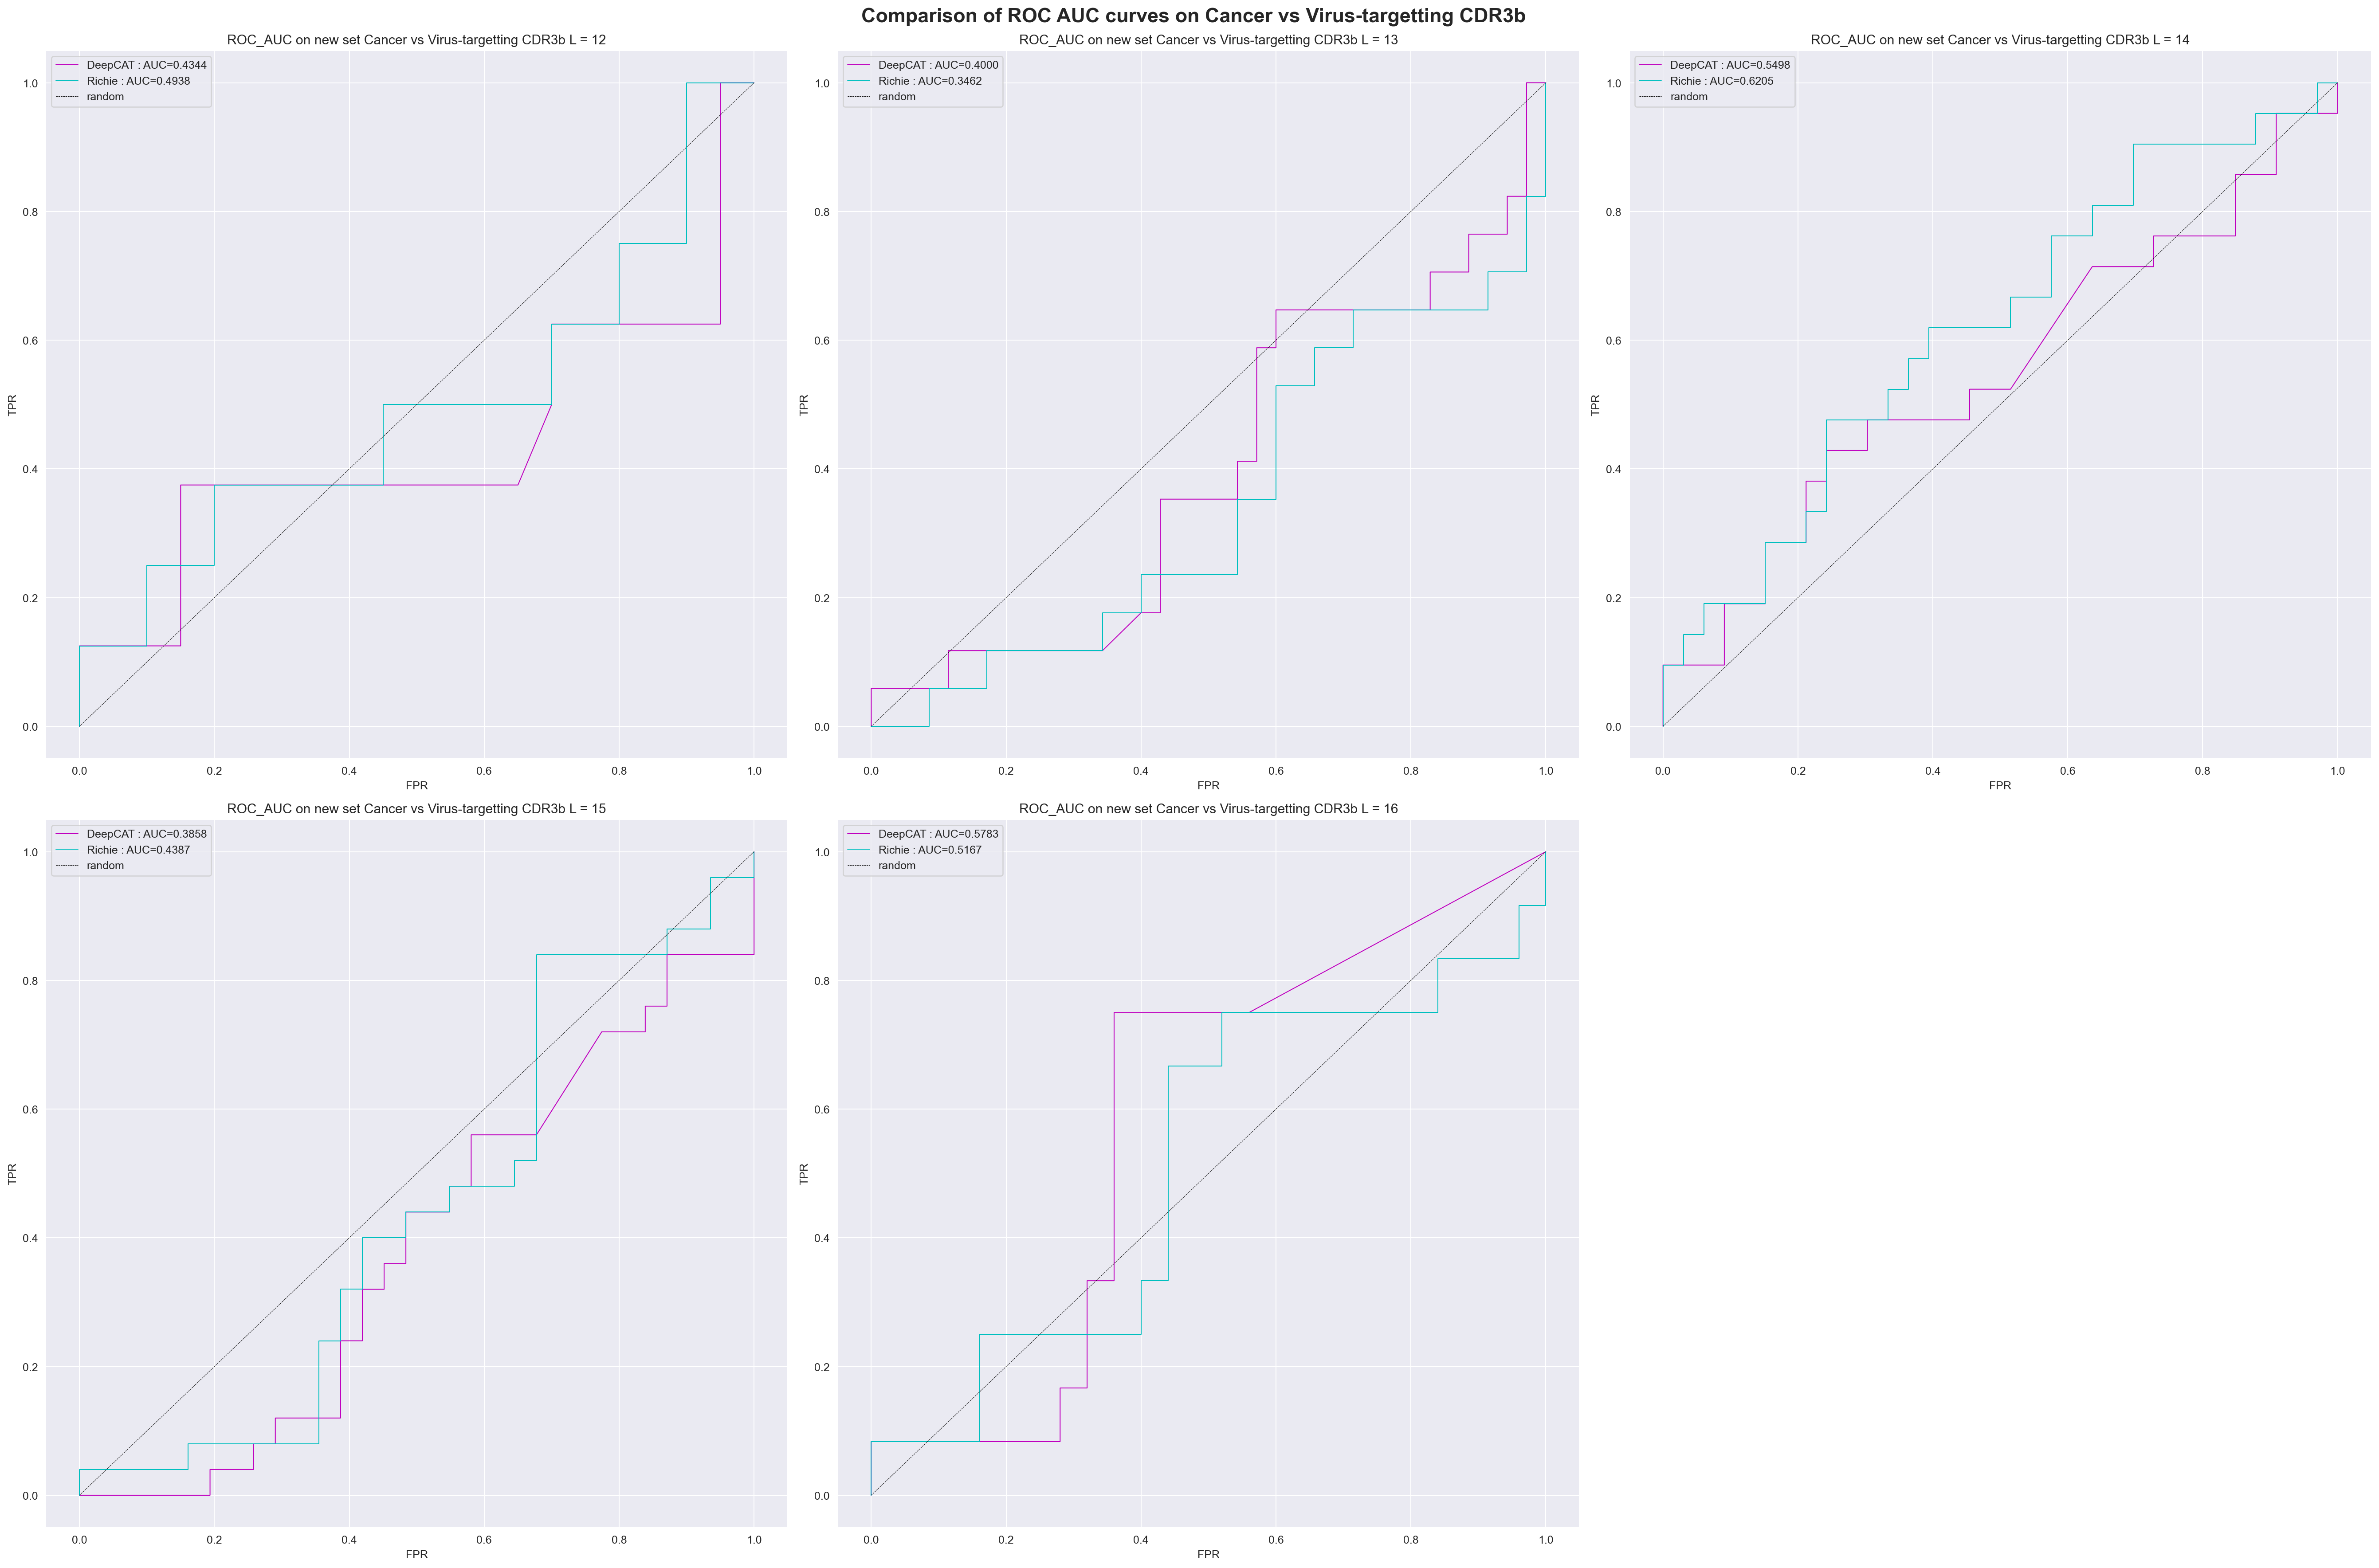

In [27]:
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
#Getting models
models = load_models('../output/training_output/richie_minmax_redo_withnograd/',
                     arch = 'richie', eval_=True)
deepcats = load_models('../output/training_output/benchmark/', arch='deepcat', eval_=True)
#Some new data to test
cancer = pd.read_csv('../NewData/tcr3db/cancer_tcr.csv', header=0)
cancer['len']=cancer.apply(lambda x: len(x['cdr3b']),axis=1)
virus = pd.read_csv('../NewData/tcr3db/virus_tcr.csv', header=0)
virus['len']=virus.apply(lambda x: len(x['cdr3b']),axis=1)

feat_dict, lab_dict = generate_features_labels(cancer['cdr3b'].values, virus['cdr3b'].values,
                                               encoding='aa_atchley', scaling='minmax')

deep_feats, deep_labels = generate_features_labels(cancer['cdr3b'].values, virus['cdr3b'].values,
                                               encoding='aaidx', scaling=None)

from sklearn.metrics import accuracy_score
for l in RANGE:
    mod12 = models[l]
    deep = deepcats[l]
    deep.eval()
    mod12.eval()
    a,b,c = mod12(feat_dict[l])
    _,z,_ = deep(deep_feats[l])
    print(l, "\n\tmod12 : {}\n\tDeepcat : {}".format(accuracy_score(lab_dict[l],b), accuracy_score(deep_labels[l],z)))
    #print()
    
acc_dict = {}
auc_dict = {}
curves_dict = {}
deepcat_curves = {}
for key in range(12,17):
    model = models[key]
    deep = deepcats[key]
    _, acc, auc, _, curve = eval_model(model, feat_dict[key], lab_dict[key],
                                       return_curve=True)
    _, _, deep_auc, _, deepcurve = eval_model(deep, deep_feats[key], deep_labels[key],
                                              return_curve = True)
    acc_dict[key] = acc
    auc_dict[key] = auc
    curves_dict[key] = (auc,curve)
    deepcat_curves[key] = (deep_auc, deepcurve)

plot_roc_comparison(deepcat_curves, curves_dict, 
                    name = 'Cancer vs Virus-targetting CDR3b', 
                   save = 'cancer_virus_cdr3b.jpg')

## PCA on test/train set predictions

#### Some helper functions here
- onehot_aa(seq)
- onehot_decode(onehot)
- get_data_df(filename, y_true=0)
- get_feats(df)
- return_class(row) for df.apply()

In [6]:
#manual 1hot encode lol
AA_KEYS = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
           'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
char_to_int = dict((c,i) for i,c in enumerate(AA_KEYS))
int_to_char = dict((i,c) for i,c in enumerate(AA_KEYS))

def onehot_aa(seq):
    int_encoded = [char_to_int[char] for char in seq]
    onehot_encoded = list()
    for value in int_encoded:
        letter = [0 for _ in range(len(AA_KEYS))]
        letter[value] = 1
        onehot_encoded.append(letter)
    return np.array(onehot_encoded).flatten()#, np.array(onehot_encoded).flatten()

def onehot_decode(onehot):
    return int_to_char[argmax(onehot[0])]
    
                    
def get_data_df(filename, y_true):
    "reads the sequences, get the dataset name, seq len, features encoding, onehot encoding"
    temp = read_seq(filename)
    temp = pd.DataFrame(data=[(x, len(x), y_true) for x in temp if (len(x)>=12 & len(x) <=16)],
                       columns = ['sequence', 'length','y_true'])
    #temp['feats'] = temp['sequence'].apply(aaidx_atchley_encoding)
    temp['onehot_flat'] = temp['sequence'].apply(onehot_aa)
    return temp

def get_merged_seqs(filename1, filename2):
    a = read_seq(filename1)
    b = read_seq(filename2)
    concat = np.append(a,b)
    return concat

def get_feats(df):
    feats = []
    for seq in df['sequence'].values:
        feats.append(aaidx_atchley_encoding(seq,None,'minmax'))
    return torch.stack(feats)

def return_class(x):
    if (x['y_true']==x['y_pred'] and x['y_pred']==1):
        return 'tp' 
    if (x['y_true']==x['y_pred'] and x['y_pred']==0):
        return 'tn' 
    if (x['y_true']!=x['y_pred'] and x['y_pred']==1):
        return 'fp' 
    if (x['y_true']!=x['y_pred'] and x['y_pred']==0):
        return 'fn' 

- get_final_df(df,top=100)

In [7]:
from sklearn.decomposition import PCA 
pca = PCA(n_components=2)
def get_final_df(df, top=100):
    X={}
    pca_dict={}
    ll=df['length'].iloc[0]
    #Getting preds and probs
    feats = get_feats(df)
    _, preds, probs = models[ll](feats)
    df['prob_cancer']= probs[:,1].detach().cpu()
    df['y_pred'] = preds.detach().cpu()
    #Getting onehot features for PCA
    X[ll] = np.array([x for x in df['onehot_flat']])
    pca_dict[ll] = pca.fit_transform(X[ll])
    df['PCA1']=pca_dict[ll][:,0]
    df['PCA2']=pca_dict[ll][:,1]
    #df['PCA3']=pca_dict[ll][:,2]
    #Arbitrary threshold
    df['above_thr']=df['prob_cancer']>0.7
    #Getting tp/fp/tn/fn
    df['pred_type']=df.apply(return_class, axis=1)
    df['top'] = 0
    df.loc[df.sort_values("prob_cancer",ascending=False)[0:top].index, ['top']] = 1
    df =  df[['sequence','length','y_true','y_pred','pred_type',
              'prob_cancer','top','above_thr','PCA1','PCA2','onehot_flat']]
    return df

In [8]:
#Reading seqs and filtering 
control = get_data_df(files[0], 0)
control_test = get_data_df(files[1], 0)
tumor = get_data_df(files[2],1)
tumor_test = get_data_df(files[3],1)

df = pd.concat([ control_test,tumor_test]).reset_index(drop=True)
#del control;del control_test; del tumor;del tumor_test
df12 = get_final_df(df.query('length==12').copy()\
                      .reset_index(drop=True)\
                      .sample(frac=1),
                    top = 100)
df13 = get_final_df(df.query('length==13').copy()\
                      .reset_index(drop=True)\
                      .sample(frac=1),
                    top = 100)
df14 = get_final_df(df.query('length==14').copy()\
                      .reset_index(drop=True)\
                      .sample(frac=1),
                    top = 100)
df15 = get_final_df(df.query('length==15').copy()\
                      .reset_index(drop=True)\
                      .sample(frac=1),
                    top = 100)
df16 = get_final_df(df.query('length==16').copy()\
                      .reset_index(drop=True)\
                      .sample(frac=1),
                    top = 100)

<AxesSubplot:xlabel='PCA1', ylabel='PCA2'>

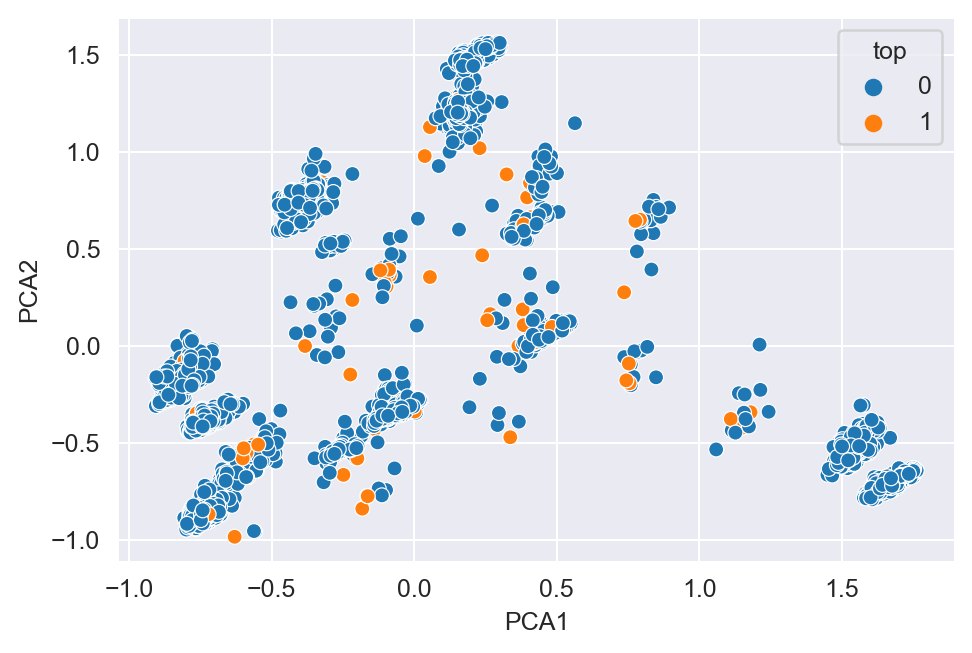

In [34]:
sns.scatterplot(data=df12,x='PCA1',y='PCA2', hue='top')

<AxesSubplot:xlabel='PCA1', ylabel='PCA2'>

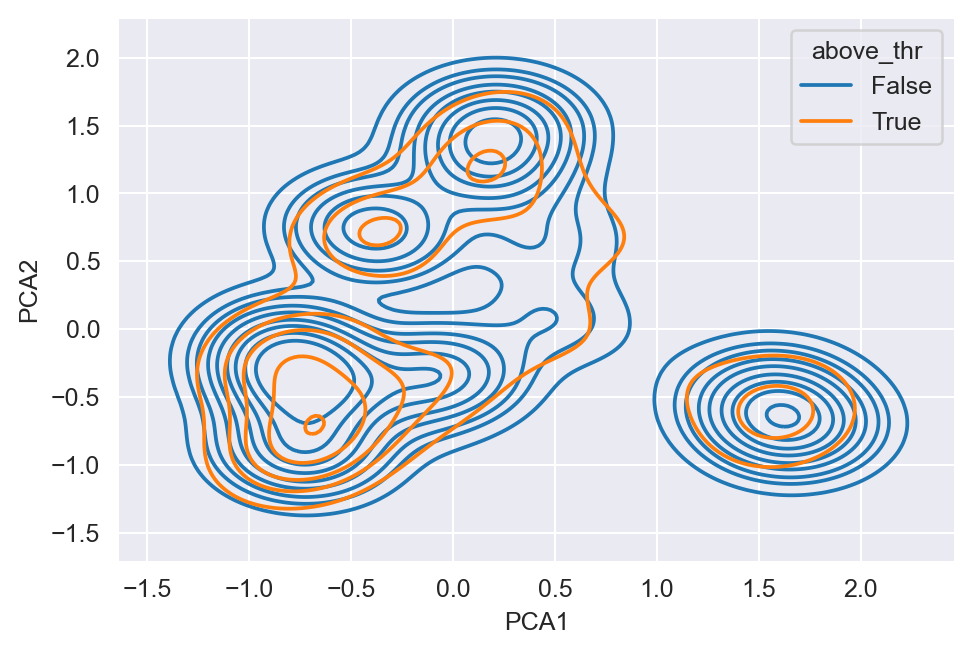

In [35]:
sns.kdeplot(data=df12,x='PCA1',y='PCA2', hue='above_thr')

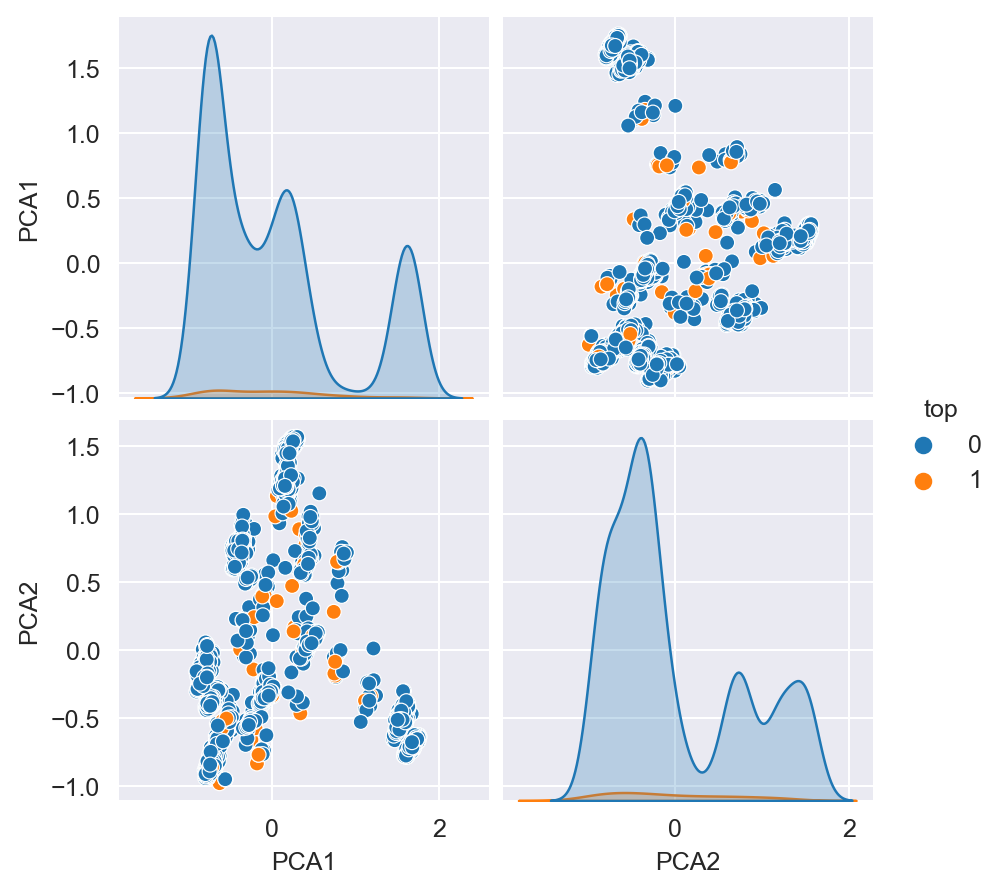

In [36]:
sns.pairplot(data=df12, vars = ['PCA1','PCA2'], hue='top')

### Hamming

In [9]:
def hamming_distance(string1, string2): 
    # Start with a distance of zero, and count up
    distance = 0
    # Loop over the indices of the string
    L = len(string1)
    for i in range(L):
        # Add 1 to the distance if these two characters are not equal
        if string1[i] != string2[i]:
            distance += 1
    # Return the final count of differences
    return distance

def hamming_df(df):
    hamms = []
    indices = df.index
    for index in indices:  
        diff = df.index.difference([index])
        row = df.loc[index,'sequence']
        for other in df.loc[diff,'sequence']:
            hamms.append(hamming_distance(row,other))
    return pd.DataFrame(data=hamms,columns=['hamm_dist'])

def get_dists(df_seqs, top_n=100):
    df_top_n = df_seqs.sort_values("prob_cancer",ascending=False)[0:top_n].copy()
    df_rest = df_seqs.loc[df_seqs.index.difference(df_top_n.index)].sample(top_n).copy()
    hamming_top = hamming_df(df_top_n)
    hamming_rest = hamming_df(df_rest)
    hamming_top['type']='top_n'
    hamming_rest['type']='rest'
    hamming_total=pd.concat([hamming_top,hamming_rest],ignore_index=True)
    return hamming_total, hamming_top, hamming_rest

In [10]:
from scipy.stats import mannwhitneyu as mwu

KeyboardInterrupt: 

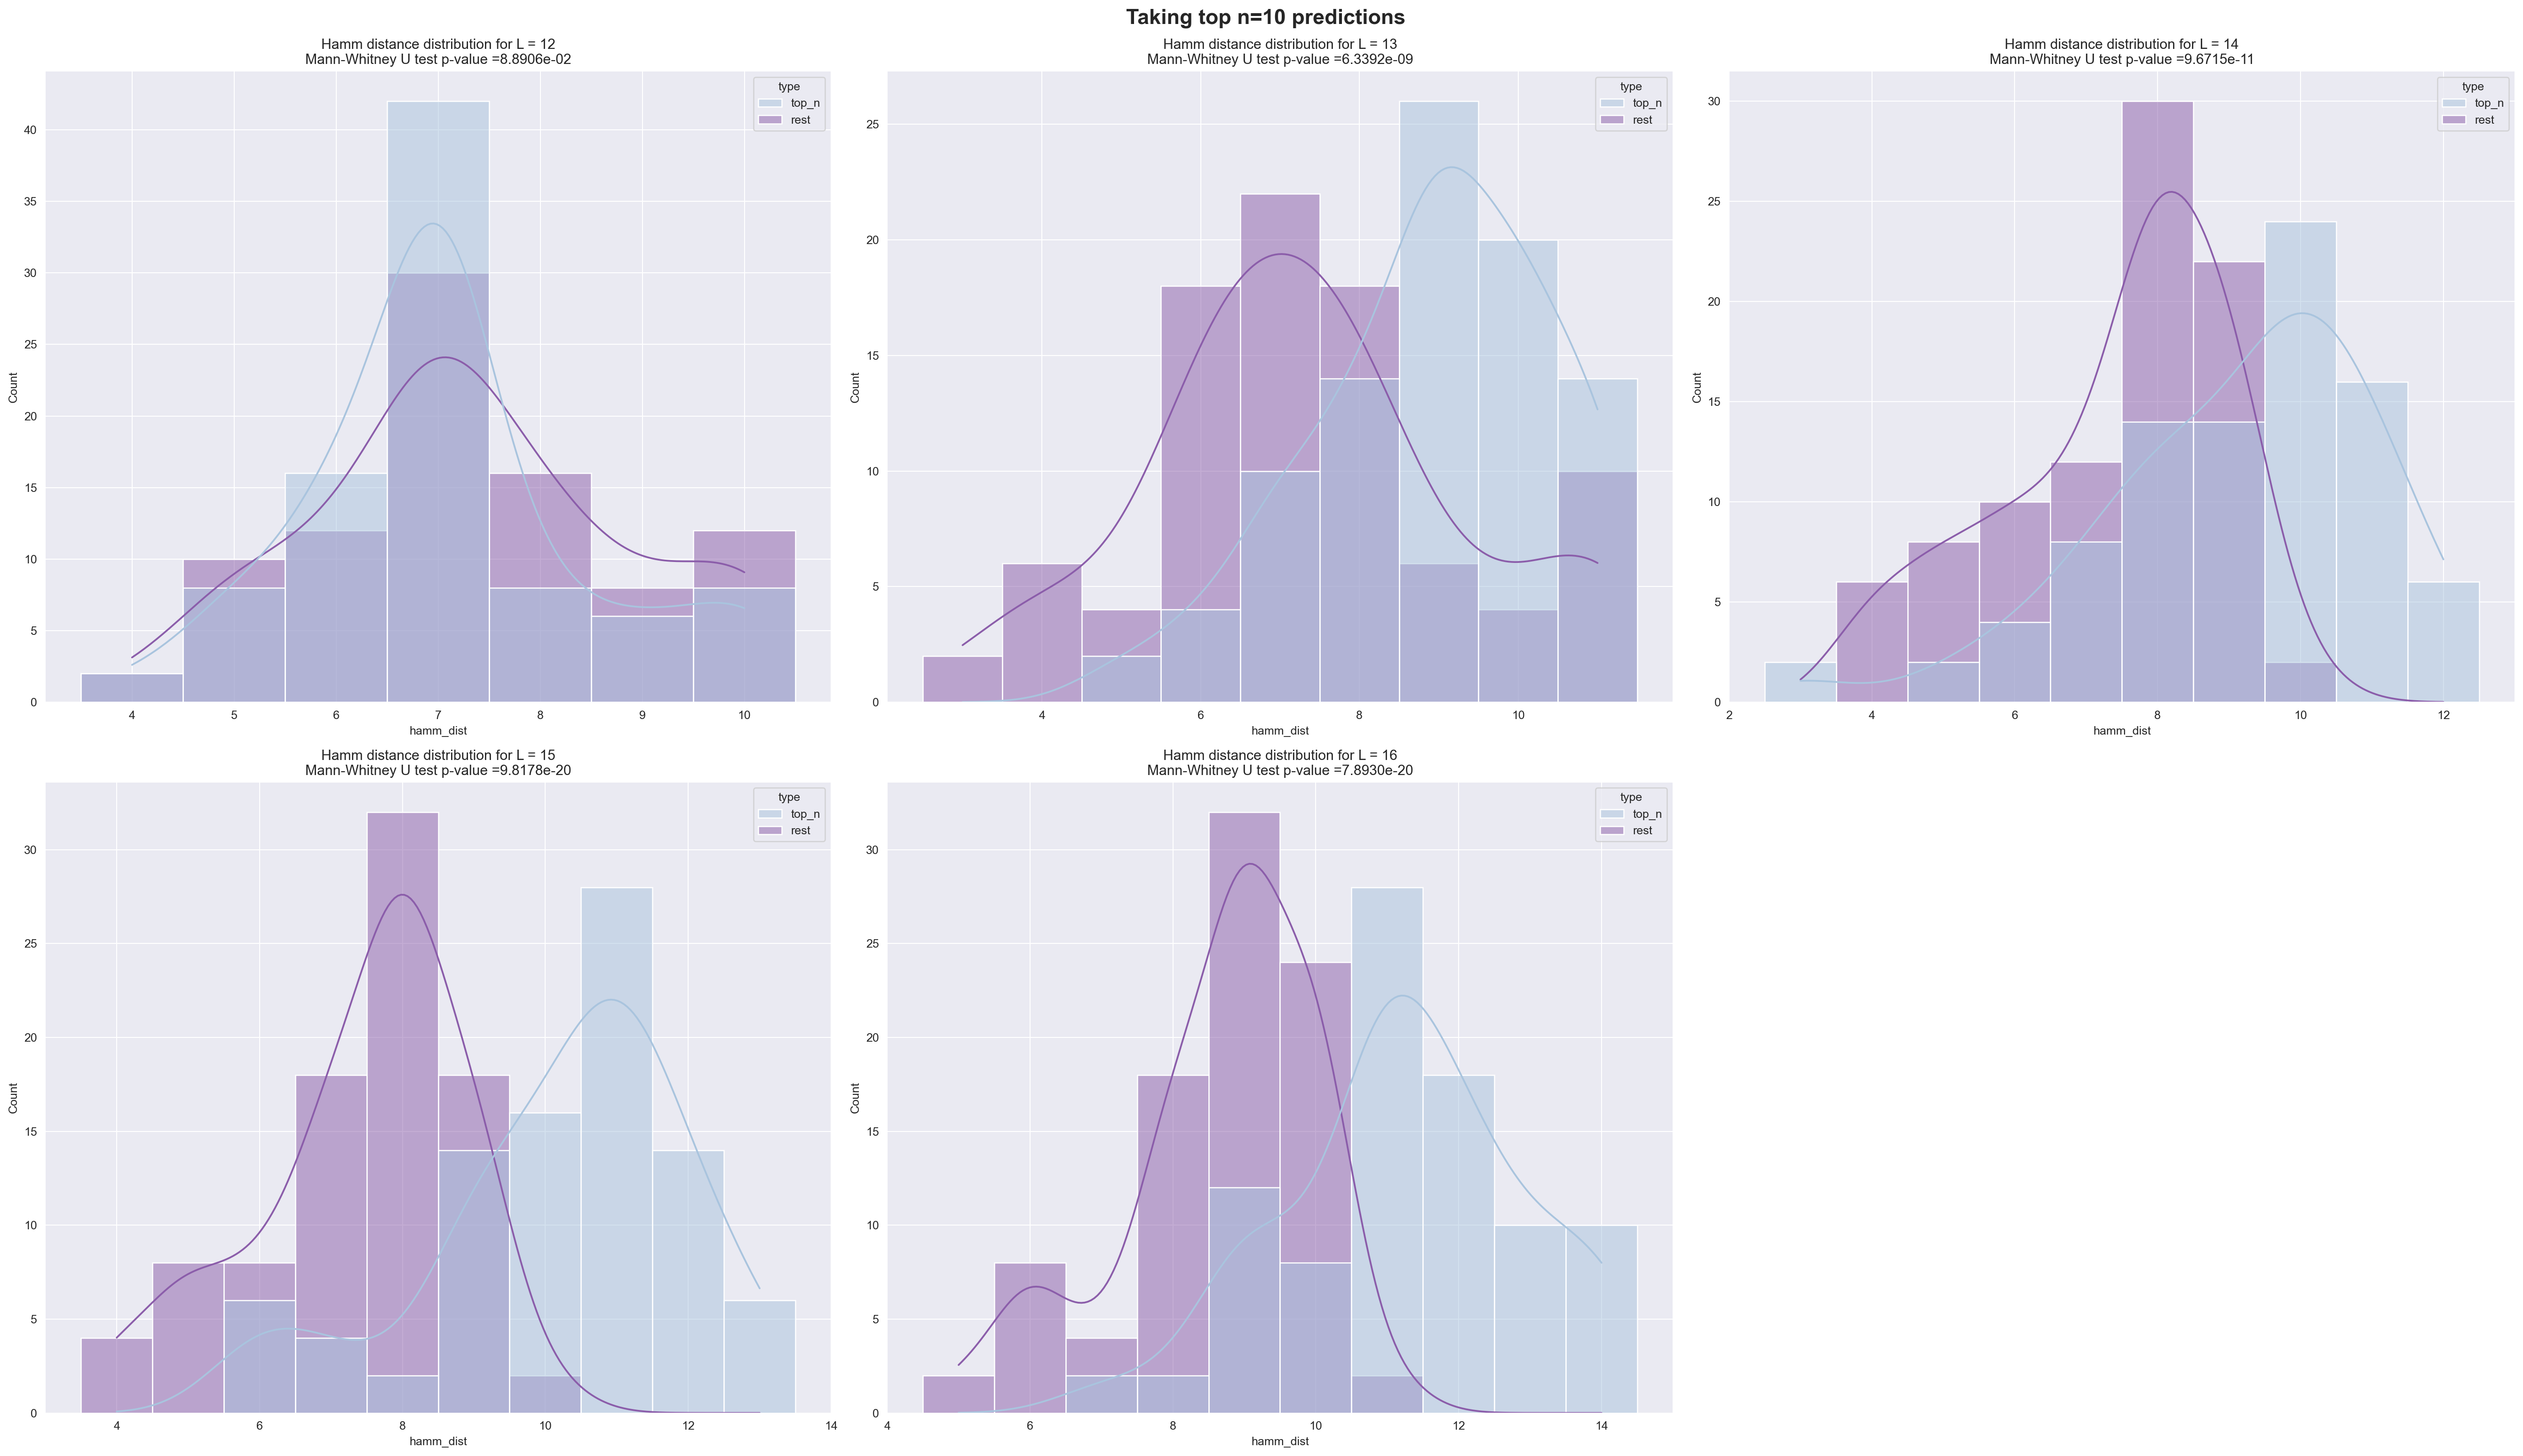

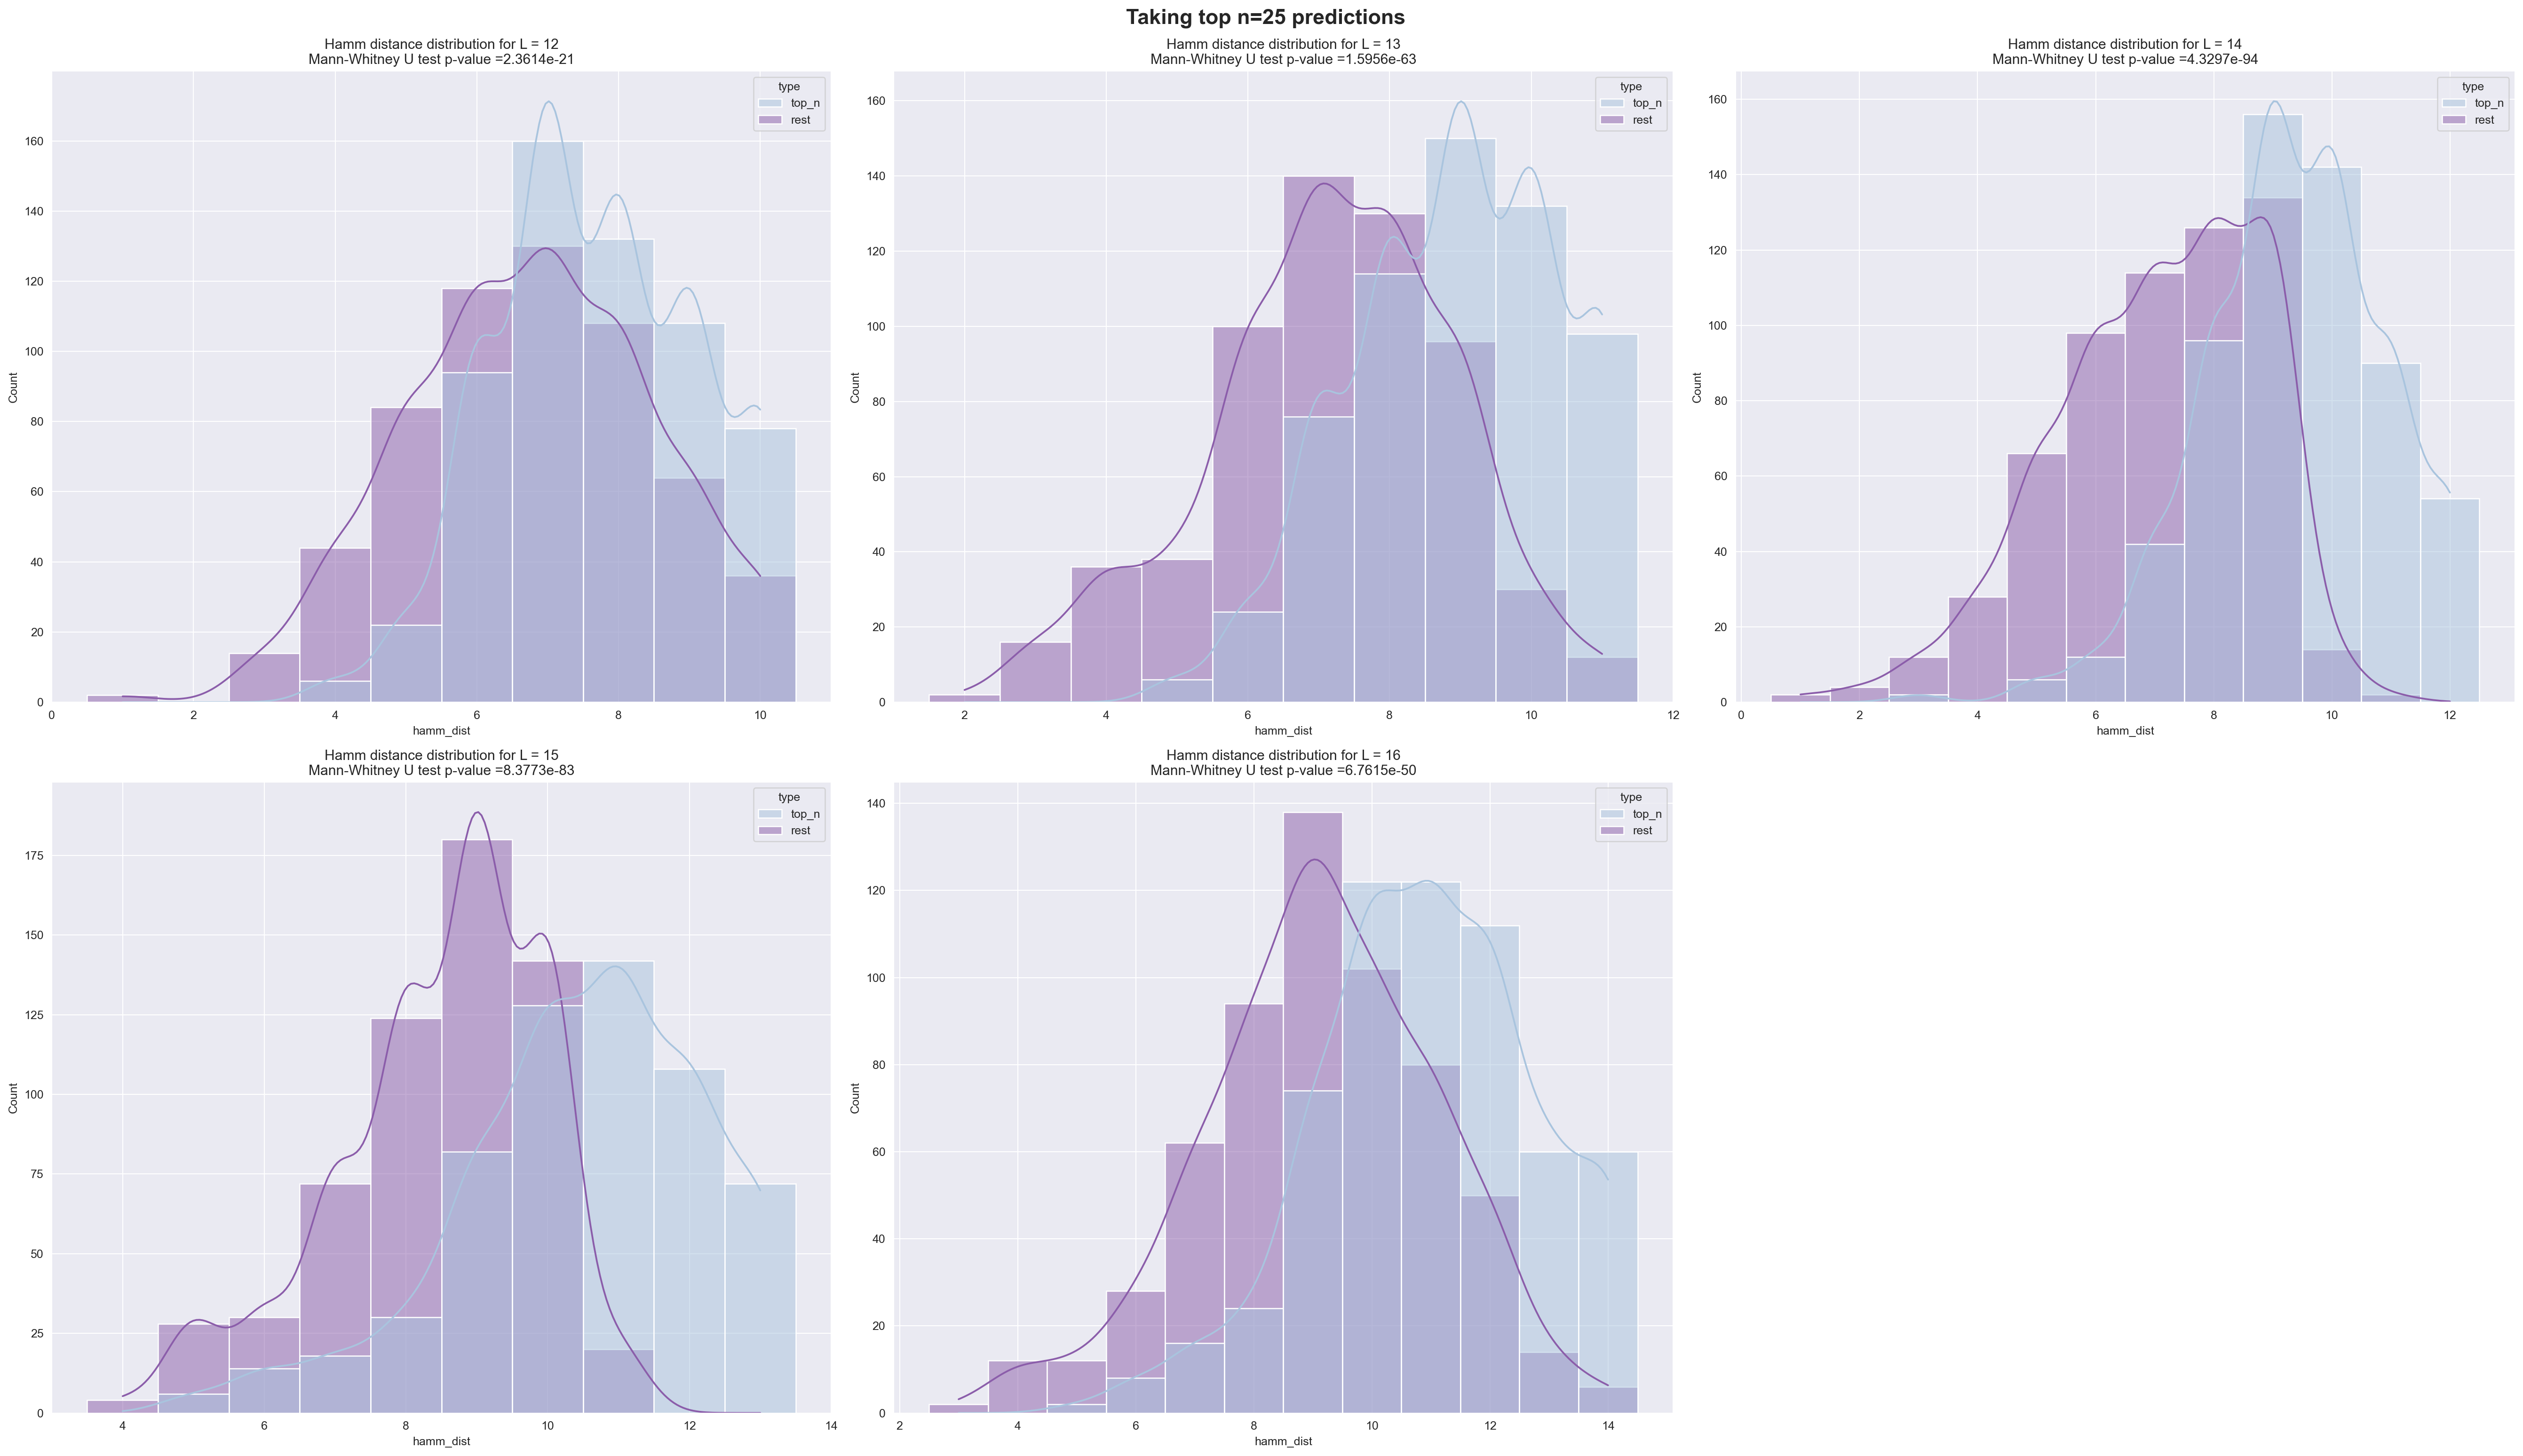

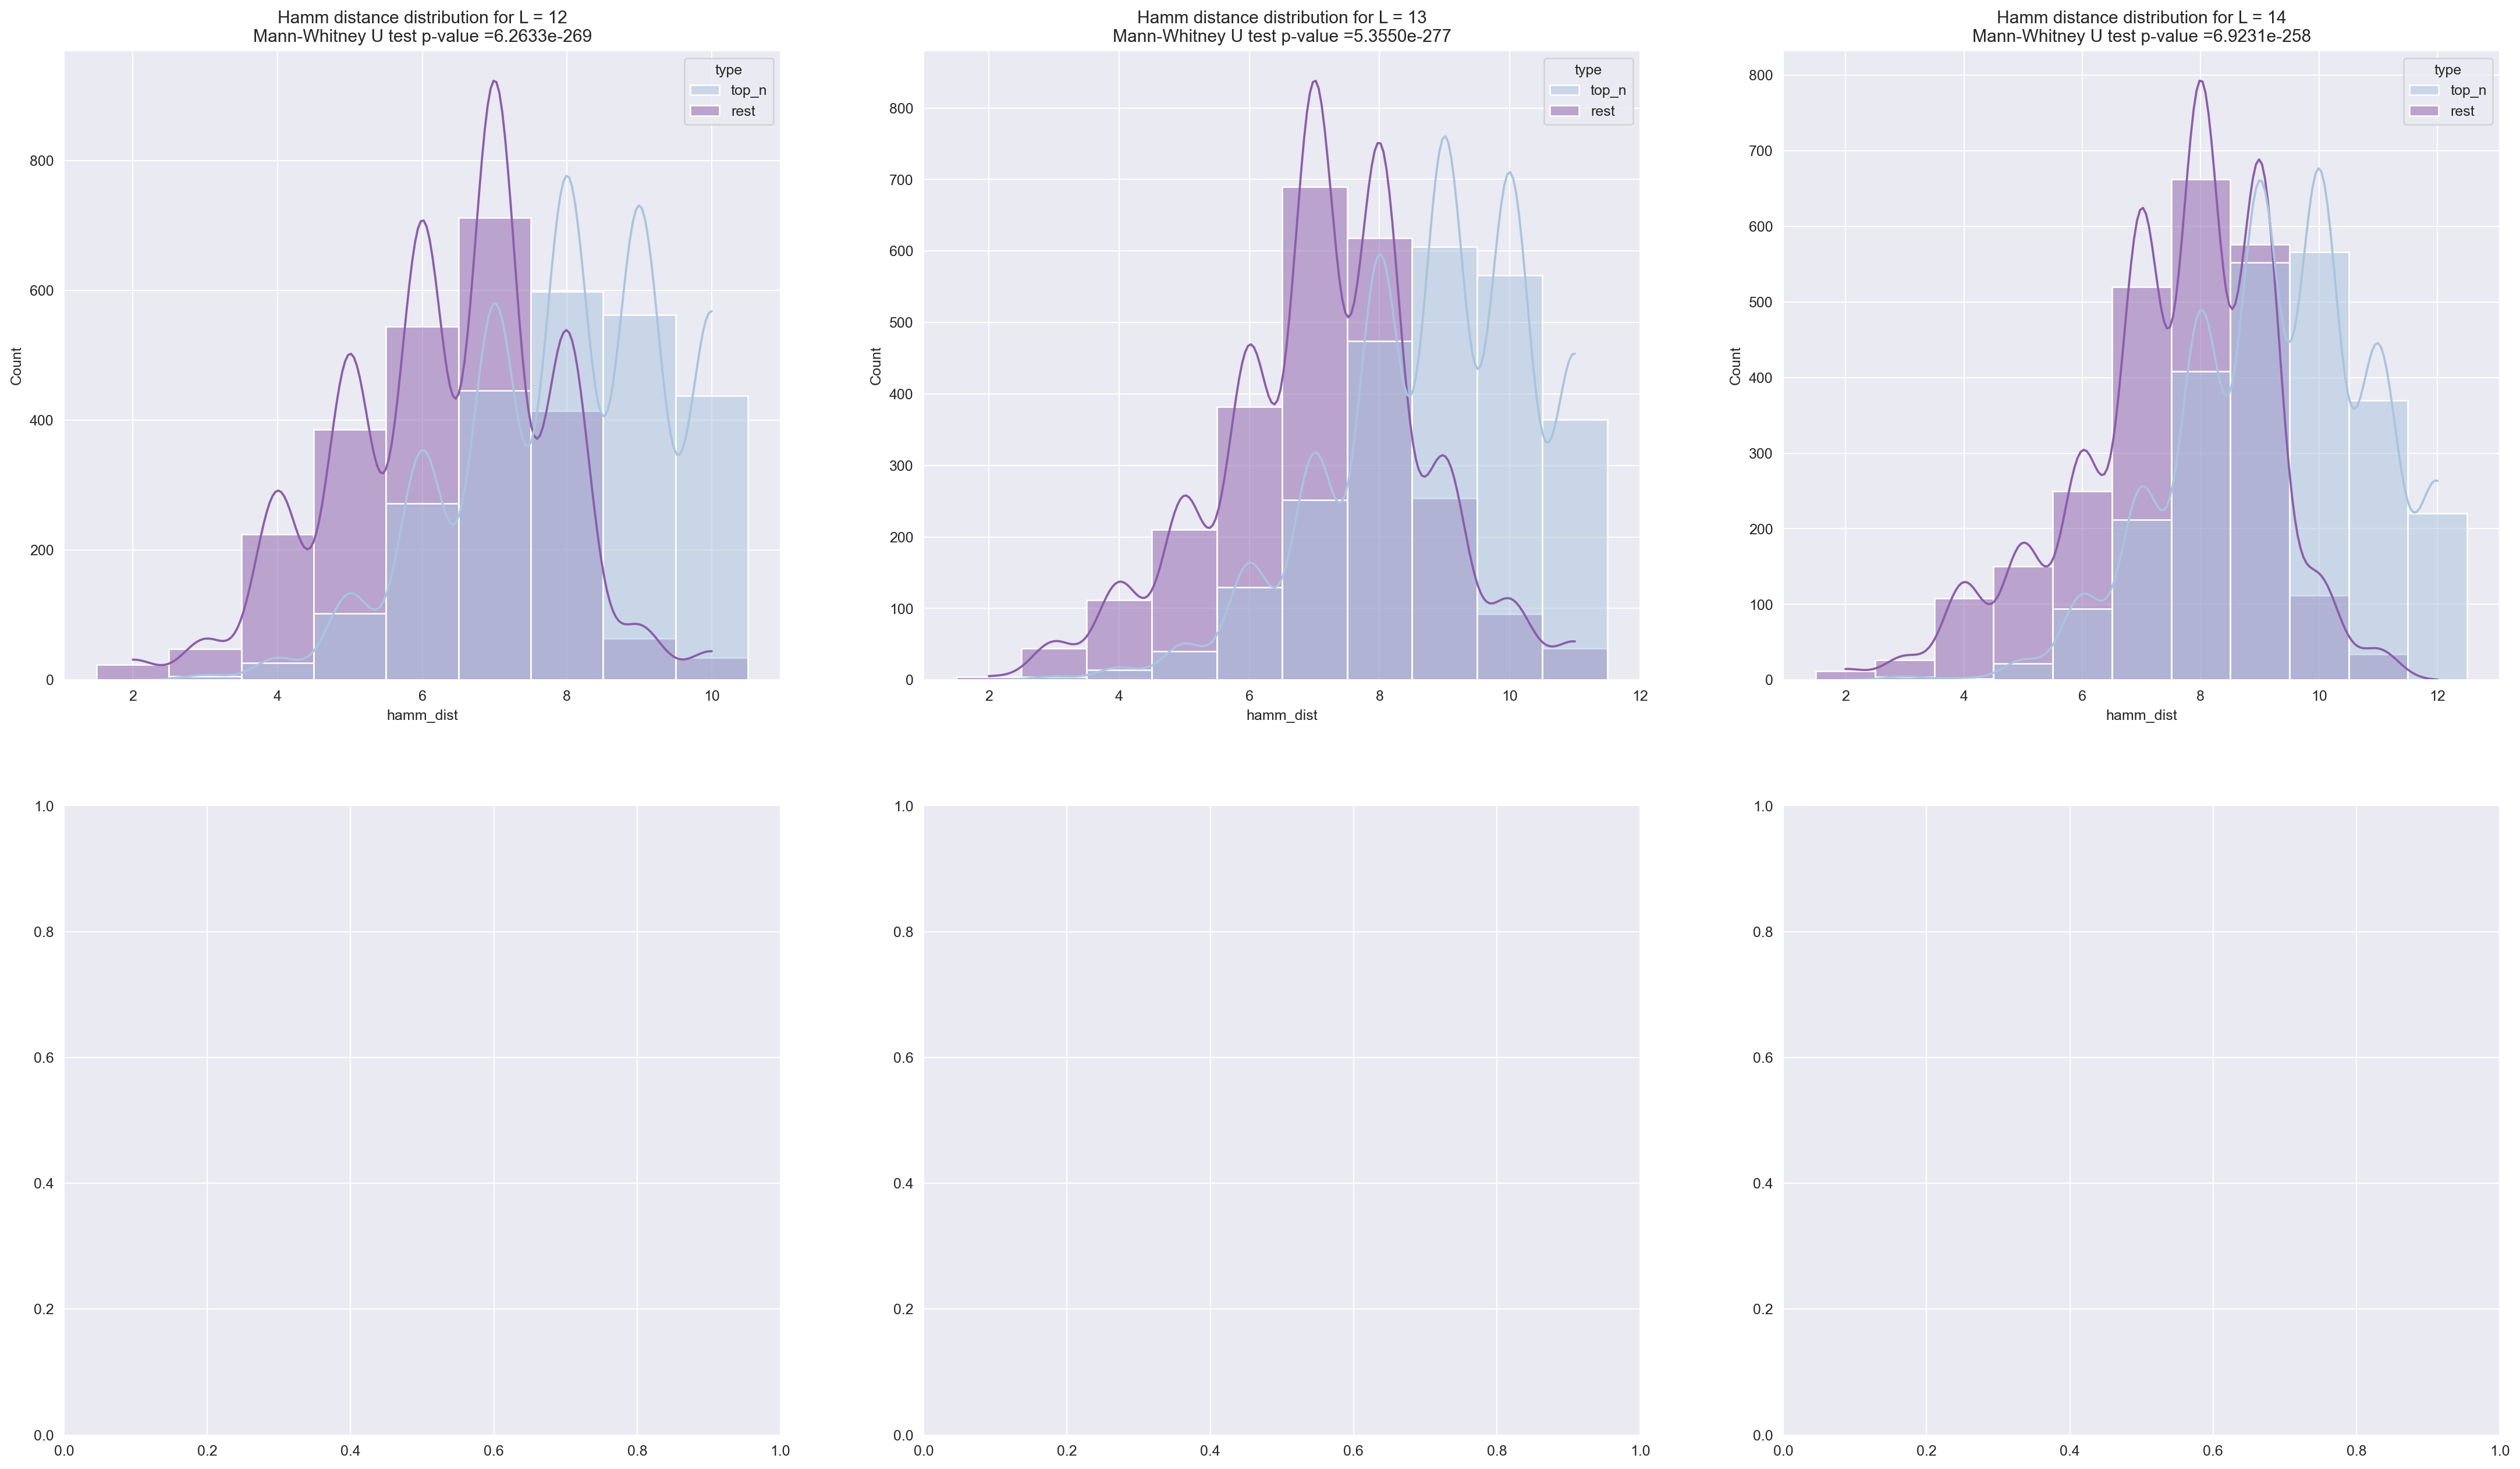

In [25]:
sns.set_palette('BuPu',n_colors=2)
for n in [10, 25, 50, 100, 200]:
    f,a = plt.subplots(2,3,figsize=(30,17.5))
    ax = a.ravel()
    for index, df in enumerate([df12, df13, df14, df15, df16]):
        total,_,_ = get_dists(df, top_n = n)
        sns.histplot(data=total, x='hamm_dist', ax=ax[index],
                     discrete=True,hue='type', kde = True)#, hue='type')
        a = total.query('type=="top_n"')['hamm_dist'].values
        b = total.query('type=="rest"')['hamm_dist'].values
        _, p = mwu(a,b)
        ax[index].set_title('Hamm distance distribution for L = {}\nMann-Whitney U test p-value ={:.4e}'.format(RANGE[index],p))
    f.suptitle('Taking top n={} predictions'.format(n), fontsize = 18, fontweight='bold')
    f.subplots_adjust(top=.95)
    f.tight_layout(rect=[0, 0, 1, 0.99])
    f.delaxes(ax[-1])
    f.savefig('hamm_distances_top'+str(n)+'.jpg', dpi=180)

In [99]:
df16_top100 = df16.sort_values('prob_cancer',ascending=False)[0:100].copy()

In [92]:
a = df16_top100.sample(1)['sequence'].item()
b = df16_top100.sample(1)['sequence'].item()
print(hamming_distance(a,b))
print(a)
print('||||||||||||||||')
print(b)

14
CASKTGRLSANTEAFF
||||||||||||||||
CSARRAYSGSEKTQYF


In [111]:
df12_top25 = df12.sort_values('prob_cancer',ascending=False)[0:25].copy()
df12_top25['sequence']


2347    CASSSGPSVPYF
2644    CSAPDGPYERYF
3050    CSAGPWPAGQFF
3156    CSARDARPGAFF
3066    CSAQQDSPEAFF
3172    CSAEGPEHTQYF
2430    CSAPGLAGRQFF
3002    CSAWGAKNIQYF
2488    CSAGDRPVEQYF
2234    CSAPGEGVPAFF
2511    CSALVDGDIQYF
2665    CAWSPLAGTRFF
2333    CSARATSFTQYF
2230    CSARDPGLEVPF
2284    CSVYRSALGAFF
2552    CSAPLGGLGYPF
2913    CATWDLFNEHFF
2760    CAWSSTAPGSVF
2306    CSASSAQLGQYF
3162    CASWDSPQTQYF
2950    CSATRPWETQYF
3135    CSVAPGTVQQFF
2868    CSARPSEGAQYF
2569    CAWSVAKNIQYF
2902    CASSSTLAIQFF
Name: sequence, dtype: object

In [ ]:
CASSSGPSVPYF
CSAPDGPYERYF
CSAGPWPAGQFF
CSARDARPGAFF
CSAQQDSPEAFF
CSAEGPEHTQYF
CSAPGLAGRQFF
CSAWGAKNIQYF
CSAGDRPVEQYF
CSAPGEGVPAFF
CSALVDGDIQYF
CAWSPLAGTRFF
CSARATSFTQYF
CSARDPGLEVPF
CSVYRSALGAFF
CSAPLGGLGYPF
CATWDLFNEHFF
CAWSSTAPGSVF
CSASSAQLGQYF
CASWDSPQTQYF
CSATRPWETQYF
CSVAPGTVQQFF
CSARPSEGAQYF
CAWSVAKNIQYF
CASSSTLAIQFF